# Parte 3: Contornos activos

#### Grupo 1: María Pardo, Mariana Nakagawa, Gema Pérez
Índice de los pasos a seguir:
1. Algoritmo snakes
2. Implementación del algoritmo de contorno activo de *skimage*
3. Segmentación de estructuras anatómicas
4. Comparativa con Watershed y Crecimiento de regiones
5. Referencias
6. Autoría

## 1. Algoritmo snakes

En los anteriores *notebooks* hemos expuesto varios métodos de segmentación, y en este definiremos otro basado en la técnica de contornos activos.

Los bordes de una imagen son una característica importante a la hora de realizar análisis de imagen. Son alteraciones en la orientación de las superficies o modificaciones de las cualidades del material. El objetivo del método de contornos activos o "snakes", es aproximar una línea iterativamente alrededor de la región objetivo, de tal manera que se acople lo máximo a sus bordes delimitantes adaptándose así a su topología.

Al adaptarse, esta línea presenta una forma ondulante asemejándose a una serpiente y por ello se le denomina informalmente como 'snakes'.  

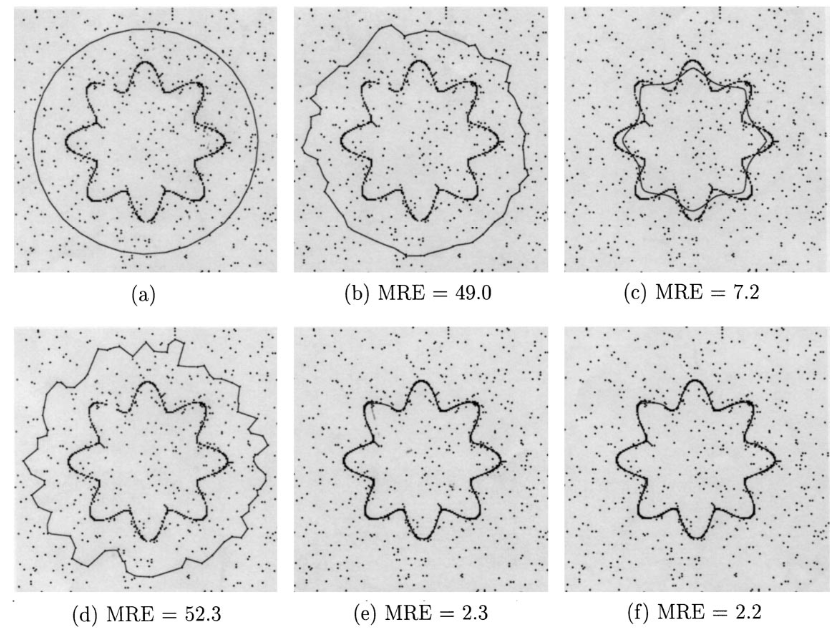


$$ C. Xu, J.L. Prince (1998) $$
(MRE: maximum radial  error) 

 ### ¿Cómo conseguimos que converja?
 
 Este algoritmo busca minimizar la energía de determinada por la imagen. Cuanto menor sea esta energía, mejor será la segmentación. Nuestra curva converge una vez logramos minimizar la energía de la curva. 
 
 $$ Energía = Energía_{interna} + Energía_{externa}$$

Si definimos a la curva **r**(s), 0 ≤ s ≤ 1 cuyo vector **r**(s) contiene las coordenadas (x,y) de los puntos de la recta:

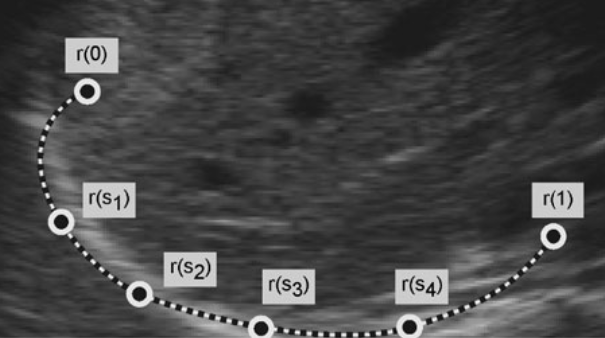

$$ Klaus D. Toennies (2012) $$

* La energía interna a minimizar se determina como:

$$ E_{interna}(\textbf{r}(s)) = w_1 \frac{∂\textbf{r}(s)}{∂s} + w_2\frac{∂^{2}\textbf{r}(s)}{∂s^{2}} = min ; w_1, w_2 > 0  $$

Esta energía está definida como la suma ponderada de la primera derivada parcial de **r**(s) (que se corresponde con la *elasticidad*) y  la segunda derivada parcial de **r**(s) (que se corresponde con la *rigidez*). La energía interna se comporta de manera similar a una goma elástica, excepto en situaciones extremas cuando se estira mucho hasta el punto de ruptura.

* Por otro lado, la energía externa está a menudo relacionada con el gradiente de la imagen, haciendo que el contorno activo siga los altos gradientes de la imagen.

$$ E_{externa}(\textbf{r}(s)) = - \lvert \nabla f(\textbf{r}(s)) \rvert = min  $$ 


De esta manera el criterio de convergencia es que cumpla la minimización de la energía total:


$$ \int_{0}^{1} E_{interna}(\textbf{r}(s)) +  E_{externa}(\textbf{r}(s))  \,ds = min $$




Al buscar una función que minimice la función anterior nos queda la siguiente expresión de Euler–Lagrange:

$$ -w_1 \frac{1}{∂s}(\frac{∂\textbf{r}(s)}{∂s}) + w_2 \frac{1}{∂s^{2}} (\frac{∂^{2}\textbf{r}(s)}{∂s^{2}}) + \nabla  E_{externa}( \textbf{r}(s)) = 0 $$




A partir de la ecuación anterior podemos llegar a una expresión que nos indica la manera en la que los puntos de la curva se van ajustando (tanto en la coordenada 'x' como en la 'y') por cada iteración, hasta que esta converge: 

$$ \textbf{x}^{(t+1)} = (\textbf{A} - \gamma \textbf{I})^{-1} ( \textbf{x}^{(t)} - \frac{∂ E(\textbf{s}^{(t)})}{∂ x} )$$


$$ \textbf{y}^{(t+1)} = (\textbf{A} - \gamma \textbf{I})^{-1} ( \textbf{y}^{(t)} - \frac{∂ E(\textbf{s}^{(t)})}{∂ x}) $$

* **A** es una matriz de constantes 
* **I** es la matriz identidad. 
*  $\gamma$ que corresponde con el coeficiente de actualización.
* El valor de t es el número de la iteración, estableciendo a t=0 como la primera iteración. 
* $\textbf{x}^{(t)}$ e $\textbf{y}^{(t)}$ son el valor estimado inicial para un punto de la curva.
* $\textbf{x}^{(t+1)}$ e $\textbf{y}^{(t+1)}$ son el valor del punto de la curva actualizado para la siguiente iteración.

$$ $$




## 2. Implementación del algoritmo de contorno activo de *skimage*

El esquema simplificado de lo que queremos implementar en el algoritmo *snakes* es el siguiente:

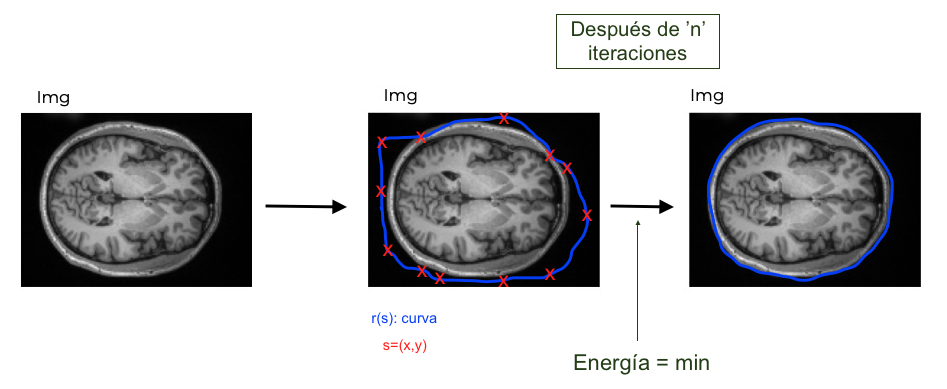

En la que la curva final que obtengamos segmentando la zona de la imagen corresponda con aquella que minimiza la energía total.

Procedemos con el código de skimage:

In [33]:
import numpy as np
import skimage
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.transform import resize

In [34]:
#cargamos la imagen 
img = nib.load('/Users/gemaperez/Imagen/bd_schizo/sub-01/anat/sub-01_T1w.nii.gz')  

from nilearn import plotting

#realizamos un resize de la imagen para ganar tiempo a la hora de ejecutar
a = np.array(skimage.transform.resize(img.dataobj, (120,180))) 
img= a[:,:,128] #obtenemos un corte 

#normalizamos
img_o=img
img_o=img_o/np.max(img_o) 

#convertimos la imagen a escala de grises
img= rgb2gray(img_o)

<ipython-input-34-458dacc6f46e>:15: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  img= rgb2gray(img_o)


Implementamos la función de contornos de skimage. En este caso los parámetros son:

   *  **gamma**: (*float*), parámetro de salto de tiempo explícito.
   *  **beta**: (*float*), parámetro de suavidad de la forma de la serpiente. Valores más altos hacen que la serpiente sea más suave.
   *  **alpha**: (*float*), parámetro de forma de la longitud de la serpiente. Valores más altos hacen que la serpiente se contraiga más rápido.

## 3. Segmentación de estructuras anatómicas

### Cabeza, sustancia negra y lóbulos

In [35]:
#implementamos la función de contornos activos de skimage para las tres estructuras anatómicas

#generamos un array de 0 a 2pi de 400 datos de longitud
s = np.linspace(0, 2*np.pi, 400)

# generamos las funciones con las que vamos a construir la curva de la cabeza 
r_head = 60 + 55*np.sin(s) 
c_head = 85 + 70*np.cos(s)
init_head = np.array([r_head, c_head]).T

snake_head = active_contour(gaussian(img, 3),
                       init_head, alpha=0.004, beta=10, gamma=0.002, coordinates='rc') #Coordinates must be set in a row-column format.

# generamos las funciones con las que vamos a construir la curva de la sustancia negra
r_black = 70 + 51.5*np.sin(s)
c_black = 180 + 50.5*np.cos(s)
init_black = np.array([r_black, c_black]).T

snake_black = active_contour(gaussian(img, 3),
                       init_black, alpha=0.030, beta=80, gamma=0.015, coordinates='rc')

# generamos las funciones con las que vamos a construir la curva de la lóbulos
r_lobs = 60 + 23.5*np.sin(s)
c_lobs= 65 + 23*np.cos(s)
init_lobs= np.array([r_lobs, c_lobs]).T

snake_lobs = active_contour(gaussian(img, 3),
                       init_lobs, alpha=0.030, beta=80, gamma=0.015, coordinates='rc')

(Text(0.5, 1.0, 'lóbulos snakes'), (0.0, 180.0, 120.0, 0.0))

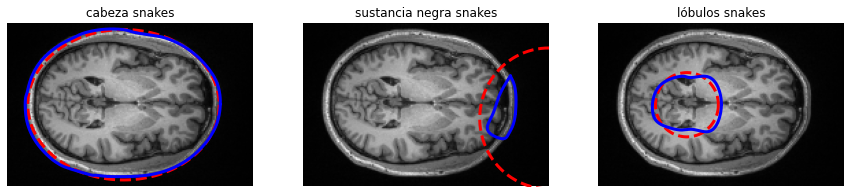

In [36]:
%matplotlib inline

#Plots de las imágenes
fig = plt.figure(figsize=(15,15))
#cabeza
plt.subplot(131)
plt.imshow(img, cmap=plt.cm.gray)
plt.plot(init_head[:, 1], init_head[:, 0], '--r', lw=3)
plt.plot(snake_head[:, 1], snake_head[:, 0], '-b', lw=3)
plt.xticks([]), plt.yticks([])
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.title('cabeza snakes'), plt.axis('off')
#sustancia negra
plt.subplot(132)
plt.imshow(img, cmap=plt.cm.gray)
plt.plot(init_black[:, 1], init_black[:, 0], '--r', lw=3)
plt.plot(snake_black[:, 1], snake_black[:, 0], '-b', lw=3)
plt.xticks([]), plt.yticks([])
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.title('sustancia negra snakes'), plt.axis('off')
#lóbulos
plt.subplot(133)
plt.imshow(img, cmap=plt.cm.gray)
plt.plot(init_lobs[:, 1], init_lobs[:, 0], '--r', lw=3)
plt.plot(snake_lobs[:, 1], snake_lobs[:, 0], '-b', lw=3)
plt.xticks([]), plt.yticks([])
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.title('lóbulos snakes'), plt.axis('off')

#plt.show()


Como podemos apreciar, el algoritmo *snakes* es capaz de segmentar toda la región de la cabeza de nuestra imagen sin problemas. Sin embargo, a la hora de querer segmentar otras estructuras más concretas, el resultado no es tan satisfactorio. 

En la segunda imagen donde tratamos de segmentar sustancia negra, logramos que la curva se adapte en una zona concreta, pero aún así no es suficiente para poder segmentar de manera correcta la región. Para empezar, pese a que hemos tratado de aproximar lo máximo posible jugando con los parámetros gamma, alpha y beta, el resultado siempre acaba incluyendo trozos de materia gris o de meninges y hueso. Además, la zona de sustancia negra que está dentro de la curva de segmentación no constituye el total de toda la sustancia negra del cerebro, por lo que nos estamos dejando fuera un porcentaje muy alto del área de la estructura.

La poca precisión de esta segmentación se debe principalmente a que estamos utilizando una circunferencia para aproximar una zona muy irregular. 

Por último, en la tercera imagen vemos que a la hora de segmentar los dos lóbulos realiza una aproximación decente. Aún así no llega a ser tan exacto como nos gustaría, al contrario que con las dos técnicas de segmentación comentadas en los dos *notebooks* anteriores.  

## 4. Comparación con watershed y crecimiento de regiones

A continuación vamos a comparar el resultado de segmentar una determinada zona de nuestra imagen con *snakes*, segmentación por crecimiento de regiones y con watershed. 

Para ello hemos decidido segmentar la estructura de 'sustancia negra', puesto que es la estructura común que segmentamos en los tres *notebooks*.

In [37]:
import modules
from scipy import ndimage
import scipy.ndimage.filters as flt
from skimage import filters
#%matplotlib inline

Using matplotlib backend: MacOSX
[[ 56 147]
 [ 91 107]
 [ 42  63]
 [ 25  40]
 [ 98  48]
 [ 68  21]]
[58, 147]


(Text(0.5, 1.0, 'Sustancia negra snakes'), (0.0, 180.0, 120.0, 0.0))

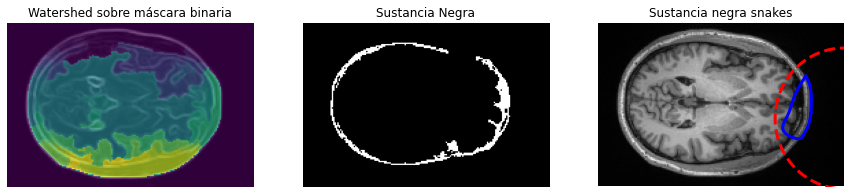

In [38]:
# watershed
%matplotlib auto

#filtro de mediana antes de implementar watershed
img_medianfiltered = flt.median_filter(img,size = 5,mode='reflect')
#watershed
watershed1, watershed_black =modules.WatershedExerciseP2(img_medianfiltered,6)
img_sobel=filters.sobel(img_medianfiltered)

#crecimiento de regiones, 'sustancia negra'
regiones3 = modules.RegionGrowingP2(img, 0.1, 0.15)


#  plot de las imágenes 
#------------------------#

#watershed
%matplotlib inline
fig = plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(img_sobel, cmap=plt.cm.gray)
plt.imshow(watershed_black, cmap='viridis', alpha=0.7)
plt.title('Watershed sobre máscara binaria'), plt.axis('off')

#crecimiento de regiones, sustancia negra
plt.subplot(132)
plt.imshow(regiones3, cmap=plt.cm.gray)
plt.title('Sustancia Negra'), plt.axis('off')

#sustancia negra snakes 
plt.subplot(133)
plt.imshow(img, cmap=plt.cm.gray)
plt.plot(init_black[:, 1], init_black[:, 0], '--r', lw=3)
plt.plot(snake_black[:, 1], snake_black[:, 0], '-b', lw=3)
plt.xticks([]), plt.yticks([])
plt.axis([0, img.shape[1], img.shape[0], 0])
plt.title('Sustancia negra snakes'), plt.axis('off')

Estas tres imágenes observamos tres segmentaciones de la misma estructura anatómica, sustancia negra. 

La primera imagen corresponde a la segmentación por watershed. En ella se distinguen diferentes colores dependiendo de la región segmentada. El algoritmo es sensible a la posición en donde se colocan las semillas, por lo que es algo que debemos tener en cuenta. En este caso, la parte correspondiente a la sustancia negra sería aquella conformada por un color verdoso/verde-lima que se localiza por la periferia del cerebro. Sin embargo, aunque tengamos una buena aproximación del color al que corresponde la estructura que buscamos, en la imagen no está muy claro.

Este problema se debe a la complejidad de nuestra imagen, por lo que el algoritmo watershed quizás no sea la mejor opción a la hora de querer segmentar estructuras como la sustancia negra. No obstante, sí que es un buen primer paso a la hora de subdividir la imagen en subregiones (p.ej: para algortimos como split and merge). 

La segunda imagen corresponde con la segmentación por crecimiento de regiones. Este algoritmo también es muy sensible a la posición de la semilla impuesta y el valor de los umbrales de intensidad establecidos. Afortunadamente nuestra imagen no es muy ruidosa y es capaz de realizar una segmentación de la sustancia negra bastante satisfactoria. El algoritmo es capaz de segmentar gran parte de toda la sustancia negra de la imagen. 

Por último, tenemos la imagen correspondiente al algoritmo de contornos activos *'snakes'*. Como hemos comentado en el apartado anterior, la curva es capaz de realizar una aproximación correcta en una zona donde se encuentra la sustancia negra, pero no es suficiente. La curva encierra una pequeña área de la total que engloba toda la sustancia negra de la imagen, por lo que no consigue abarcar toda la estructura. Además, la curva incluye otras estructuras que no nos interesan como hueso, meninges o cortex.

En conclusión, teniendo en cuenta los resultados de los tres algoritmos implementados, el que consigue segmentar con mayor éxito la sustancia negra es el de crecimiento de regiones. Watershed no es capaz de dar un resultado claro y *'snakes'* sólo segmenta un área muy pequeña de la estructura de interés. Crecimiento de regiones es la mejor opción a la hora de segmentar esta estructura. 

## 5. Referencias

* Chenyang Xu, Jerry L. Prince (1998). '*Generalized gradient vector flow external forces for active contours*'. The Johns Hopkins University, Baltimore. https://www.sciencedirect.com/science/article/abs/pii/S0165168498001406
* Klaus D. Toennies (2012). '*Guide to Medical Image Analysis. Methods and Algorithms*'. 

## 6. Autoría

Esta práctica ha sido realizada por **Mariana Nakagawa, María Pardo y Gema Pérez**. Consideramos que las aportaciones de cada una en todos los puntos del trabajo se deben tener en cuenta. Hemos colaborado todas en la elaboración de cada algoritmo y en la solución de problemas.